In [3]:
from google.cloud import bigquery
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import json
import pickle
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
client = bigquery.Client()

In [5]:
%%bigquery breast_cancer_MLdataset

SELECT * FROM `smu-msds-7346-summer2019-mld.raw_biopsy_data.BCDatasetForModeling`

In [6]:
type(breast_cancer_MLdataset)

pandas.core.frame.DataFrame

In [9]:
df =breast_cancer_MLdataset

In [10]:
## This piece of code trains a RandomForest  Classifier
if "diagnosis" in df.columns:
    yData = df.diagnosis
    del df["diagnosis"]
    #del df["id_number"]
    #del df["Unnamed"]
xData = df
X_train, X_test, y_train, y_test = train_test_split(xData,yData)
rf_clf = RandomForestClassifier(criterion = 'gini', 
                                n_estimators = 5, verbose = False)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=False,
            warm_start=False)

In [6]:
##The trained model is used to predict house prices on the testing set
predicteddiagnosis = rf_clf.predict(X_test)

## List the predicted prices for the first 10 homes in the list
predicteddiagnosis[:10]

array(['B', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'B'], dtype=object)

In [7]:
from sklearn import metrics as mt

biopsy_acc = mt.accuracy_score(y_test,predicteddiagnosis)
conf = mt.confusion_matrix(y_test,predicteddiagnosis)

print('RandomForestClassifier accuracy:', biopsy_acc )
print(conf)

RandomForestClassifier accuracy: 0.9440559440559441
[[85  4]
 [ 4 50]]


In [8]:
precision_score=precision_score(y_test, predicteddiagnosis, average = 'binary',pos_label=str)
precision_score

ValueError: pos_label=<class 'str'> is not a valid label: array(['B', 'M'], dtype='<U1')

In [ ]:
biopsy_feature_importances = pd.DataFrame(rf_clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
biopsy_feature_importances = biopsy_feature_importances.rename_axis('feature').reset_index()
dataset_ref = client.dataset('Models')
table_ref = dataset_ref.table('RFBiopsy_Feature_Importance')

client.load_table_from_dataframe(biopsy_feature_importances, table_ref).result()

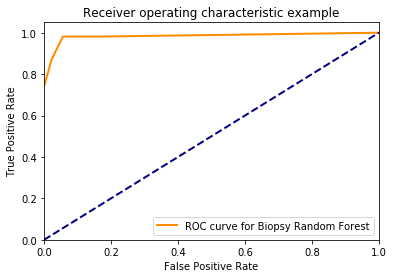

In [9]:
one_hot_encoder = OneHotEncoder()
rf_fit = rf_clf.fit(X_train, y_train)
fit = one_hot_encoder.fit(rf_clf.apply(X_train))
y_predicted = rf_clf.predict_proba(X_test)[:, 1]
false_positive, true_positive, _ = roc_curve(y_test, y_predicted, pos_label = 'M')
roc_auc = auc(false_positive, true_positive)
plt.figure()
lw = 2
plt.plot(false_positive, true_positive, color='darkorange',
         lw=lw, label='ROC curve for Biopsy Random Forest')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [10]:
%%bigquery genotype

SELECT * FROM `smu-msds-7346-summer2019-mld.raw_biopsy_data.Genotype` 

In [11]:
if "diagnosis" in genotype.columns:
    yData = genotype.diagnosis
    del genotype["diagnosis"]
    del genotype["id_number"]
    del genotype["int64_field_0"]
xData = genotype
X_train, X_test, y_train, y_test = train_test_split(xData,yData)
rf_clf = RandomForestClassifier(criterion = 'gini', 
                                n_estimators = 5, verbose = False)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=False,
            warm_start=False)

In [13]:
##The trained model is used to predict the diagnosis based on the patient's genotype
predicteddiagnosis = rf_clf.predict(X_test)

## List the predicted prices for the first 10 genomes in the list
predicteddiagnosis[:10]

array(['B', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'B', 'M'], dtype=object)

In [14]:
genotype_acc = mt.accuracy_score(y_test,predicteddiagnosis)
conf = mt.confusion_matrix(y_test,predicteddiagnosis)

print('RandomForestClassifier accuracy:', genotype_acc )
print(conf)

RandomForestClassifier accuracy: 0.5944055944055944
[[63 31]
 [27 22]]


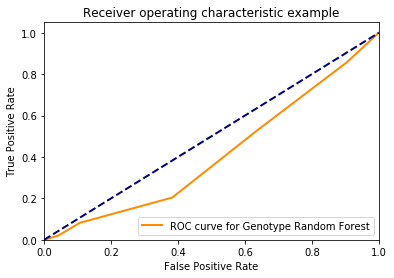

In [15]:
one_hot_encoder = OneHotEncoder()
rf_fit = rf_clf.fit(X_train, y_train)
fit = one_hot_encoder.fit(rf_clf.apply(X_train))
y_predicted = rf_clf.predict_proba(X_test)[:, 1]
false_positive, true_positive, _ = roc_curve(y_test, y_predicted, pos_label = 'M')
roc_auc = auc(false_positive, true_positive)
plt.figure()
lw = 2
plt.plot(false_positive, true_positive, color='darkorange',
         lw=lw, label='ROC curve for Genotype Random Forest')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
genotype_feature_importances = pd.DataFrame(rf_clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
genotype_feature_importances = genotype_feature_importances.rename_axis('feature').reset_index()
dataset_ref = client.dataset('Models')
table_ref = dataset_ref.table('RFGenotype_Feature_Importance')

client.load_table_from_dataframe(genotype_feature_importances, table_ref).result()

In [ ]:
acc_dict = {'RandomForest':['Biopsy','Genome'],'Accuracy':[biopsy_acc,genotype_acc]}
acc_df = pd.DataFrame(acc_dict)
dataset_ref = client.dataset('Models')
table_ref = dataset_ref.table('RFAccuracies')

client.load_table_from_dataframe(acc_df, table_ref).result()

In [ ]:
# Please do not change the code in this section!

#To save money, I did not create a new instance.
#Kmeans clustering from Biopsy dataset for patient stratification purposes. 


In [ ]:
xData.head() #verify data available

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm

In [11]:
xData.shape

(569, 30)

In [12]:
xData.dtypes

radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave_points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave_points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave_points_worst       float64
symmetry_worst      

In [13]:
xData.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [14]:
df=xData


In [15]:
#this step Worked
#normalize the reduced df4 to prepare for parallel_coordinates plots
# Methods for Scaling data:

#df=subsam_df_clean_wDummies
# 1. Min-max scaling
df_norm_MinMax = (df - df.min()) / (df.max() - df.min())

#normal scaling (0 mean 1 sd scaling)
df_norm_musigma = (df - df.mean()) / (df.std())

df_norm_medsigma = (df - df.median()) / (df.std())

In [16]:
df_norm_MinMax.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,0.310426,0.157254,0.301776,0.179343,0.407692,0.189896,0.156139,0.237624,0.416667,0.162174,...,0.255425,0.192964,0.245480,0.129276,0.480948,0.145540,0.190895,0.442612,0.278336,0.115112
1,0.288655,0.202908,0.289130,0.159703,0.495351,0.330102,0.107029,0.154573,0.458081,0.382266,...,0.233725,0.225746,0.227501,0.109443,0.396421,0.242852,0.150958,0.250275,0.319141,0.175718
2,0.119409,0.092323,0.114367,0.055313,0.449309,0.139685,0.069260,0.103181,0.381313,0.402064,...,0.081821,0.097015,0.073310,0.031877,0.404345,0.084903,0.070823,0.213986,0.174453,0.148826
3,0.286289,0.294555,0.268261,0.161315,0.335831,0.056070,0.060028,0.145278,0.205556,0.182603,...,0.191035,0.287580,0.169580,0.088650,0.170640,0.018337,0.038602,0.172268,0.083185,0.043618
4,0.308060,0.425769,0.297975,0.177094,0.314977,0.176676,0.111317,0.168191,0.378283,0.152064,...,0.256848,0.527719,0.241994,0.126229,0.297365,0.139525,0.182268,0.440550,0.257441,0.092680


In [ ]:
#import pandas_profiling
#pandas_profiling.ProfileReport(df_norm_MinMax)

In [ ]:
#from corr heatmap above, the variables have no multicolinearity issue, so ready to use for modeling
#update: wrong data last run, updated data show correlations between variables so need to feature selection for accurate results

In [17]:
#Kmeans clustering
X=df_norm_MinMax

cls = KMeans(n_clusters=6, init='k-means++',random_state=1)
cls.fit(X)
newfeature = cls.labels_ # the labels from kmeans clustering

In [18]:
X2 = np.column_stack((X,pd.get_dummies(newfeature)))
X2

array([[0.31042643, 0.15725397, 0.30177597, ..., 0.        , 0.        ,
        0.        ],
       [0.2886554 , 0.20290835, 0.28912998, ..., 0.        , 0.        ,
        0.        ],
       [0.11940934, 0.0923233 , 0.11436666, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.24747977, 0.1481231 , 0.24179393, ..., 0.        , 0.        ,
        0.        ],
       [0.30616688, 0.29049713, 0.29583305, ..., 0.        , 0.        ,
        0.        ],
       [0.33503715, 0.2526209 , 0.31760072, ..., 0.        , 0.        ,
        0.        ]])

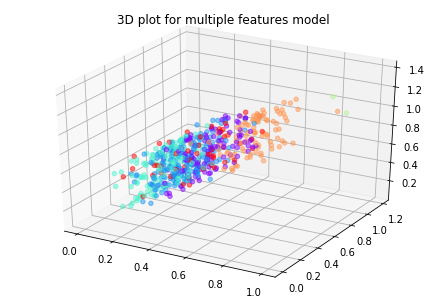

In [19]:
#Visualize cluster
#3D plot

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2,X2[:, 2]+np.random.random(X2[:, 1].shape)/2, c=newfeature, cmap=plt.cm.rainbow,alpha=0.5)
plt.title('3D plot for multiple features model')

pyplot.show()

In [ ]:
X=df_norm_MinMax

from sklearn.cluster import KMeans
%matplotlib inline
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [1]:
#run for ? min
X=df_norm_MinMax
data=df_norm_MinMax

# Silhouette vs Cluster Size
# do it for the k-means
from sklearn import metrics
from sklearn.cluster import KMeans

seuclid = []
scosine = []
k = range(2,6)
for i in k:
    kmeans_model = KMeans(n_clusters=i, init="k-means++").fit(X)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(data, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(data, labels, metric='cosine'))
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

NameError: name 'df_norm_MinMax' is not defined

In [ ]:
#Silhouette analysis
